# <center>Mouse Brain from Neurons to brain regions</center>
## <center>application of co-simulation TVB-Nest multiscale</center>

<div class="alert alert-block alert-warning">
    <h1 id="Installation before usage">Installation before usage<a class="anchor-link" href="Installation-before-usage"></a>
        </h1>
    <h3><strong>You can't run the notebook on this platform.</strong></h3>
    <h3>The step for the installation is the following:</h3>
        <ul>
            <li>Install singularity : <a href=https://singularity.lbl.gov/quickstart> https://singularity.lbl.gov/quickstart </a></li>
          <li>Download the singularity notebook : <strong>Nest_TVB_full.simg</strong> and the notebook from the Storage of the Collab in <strong>one folder</strong></li>
          <li>Open an terminal in this folder</li>
          <li>Execute the next command : <strong>singularity run --app jupyter-notebook ./Nest_TVB_full.simg</strong></li>
          <li>Open the link of the jupyter notebook</li>
          <li>Open the notebook </li>
        </ul>
</div>

In [24]:
%%capture --no-display
%matplotlib notebook
# library for the notebook
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import os
# import library of the application
from nest_elephant_tvb.simulation.parameters_manager import save_parameter,create_linked_parameters
from nest_elephant_tvb.analyse.get_data import get_rate,get_data_all
from nest_elephant_tvb.analyse.neuron_widget import neuron_widget
from nest_elephant_tvb.analyse.print_connectome import display_connectome

# hidden cell
from IPython.core.display import display, HTML, Javascript
def hide_from_add(name):
    string_code='''
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="'''+name+ '''"></form>
    '''
    return string_code
hide_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>
'''

display(HTML(hide_code_prepare_str))
def hide_from(name):
    display(HTML(hide_from_add(name)))
hide_from('import function')

# size of the autoscrolling
def size_auto_scroll(nb=100):
    display(Javascript("IPython.OutputArea.auto_scroll_threshold="+str(nb)+";"))

# color of the printing
color_Nest = 'royalblue'
color_TVB  = 'tomato'

# 1. Define the parameter of the simulation

In [25]:
param={}

## 1.1 parameter for Nest simulator

### 1.1.a parameter for Nest kernel (<a href=https://nest-simulator.readthedocs.io/en/nest-2.20.1/ref_material/pynest_apis.html#module-nest.lib.hl_api_simulation>documentation</a>)

In [26]:
param['param_nest'] = {
    "sim_resolution": 0.1,        # the precision of the simulation 
    "master_seed": 46,            # the seed for the random generator of Nest 
    "total_num_virtual_procs": 10,# the number of virtual processeur 
    "overwrite_files": True,      # 
    "print_time": True,           # print time (it's not working for the moment)
    "verbosity": 20}              # verbosity of Nest

### 1.1.b parameter of the neurons

The model of neurons is the **adaptive and exponential integrater and fire** with **exponential conductance synapses** <a href='#brette_2005'> [Brette and Gerstner 2005]</a> 

**Neuron dynamic** :

\begin{equation}
    \begin{aligned}
        C_m\times \frac{dV_m}{dt} =& -g_L(V_m-E_L)+g_L\times\Delta_T \times e^{ \frac{V_m-V_{th}}{\Delta_T} }\\
        &-g_e(t)(V_m-E_{ex}) -g_i(t)(V_m-E_{in})- \text{W} +I_e\\
        \tau_w \times \frac{d\text{W}}{dt}=& a\times(V_m-E_L) -\text{W}
    \end{aligned}
\end{equation}

**Synaptic connection** :

\begin{equation}
			g_e(t) = \sum_{t_j^{(f)}} w_j\times e^{-\frac{t-t_j^{(f)}}{\tau_{ex}}}  \, \mathcal{H}(t-t_j^{(f)})\text{ for }w_j > 0.0\\
			g_i(t) = \sum_{t_j^{(f)}} w_j\times e^{-\frac{t-t_j^{(f)}}{\tau_{in}}}  \, \mathcal{H}(t-t_j^{(f)})\text{ for }w_j < 0.0\\
\end{equation}

with $t_j^{(f)}$ is the $f^{th}$ spike of the neurons j.

__reset condition__:

$V_m ([t^{(f)};t^{(f)}+t_{ref}])=V_{reset}$ with $t^{(f)}=\{ t|V_m(t)=V_{peak}\}$\
$\text{W} ([t^{(f)};t^{(f)}+t_{ref}])=\text{W}(t^{(f)})+b$ with $t^{(f)}=\{t|V_m(t)=V_{peak}\}$

__initial condition__:

$V_m(0)=-70.6$mV and $\text{W}(0)=0.0$


__Parameter of the neurons__ :<a id="parameter_neuron"></a>

$C_m$ double - Capacity of the membrane (281.0 pF).\
$t_{ref}$ double - Duration of refractory period in (0.0 ms).\
$V_{reset}$ double - Reset value for $V_m$ after a spike (-60.0 mV).\
$E_L$ double - Leak reversal potential (-70.6 mV).\
$g_L$ double - Leak conductance (30.0 nS).\
$V_{peak}$ double - Spike detection threshold (0.0 mV).\
$a$ double - Subthreshold adaptation (4.0 nS).\
$b$ double - Spike-triggered adaptation (80.5 pA).\
$\Delta_T$ double - Slope factor (2.0 mV).\
$\tau_w$ double - Adaptation time constant (144.0 ms).\
$V_{th}$ double - Spike initiation threshold (-50.4 mV).\
$I_e$ double - Constant external input current (700 pA).\
$E_{ex}$ Excitatory reversal potential (0.0 mV)\
$\tau_{ex}$ Rise time of excitatory synaptic conductance (0.2ms)\
$E_{in}$ Inhibitory reversal potential (-85.0 mV)\
$\tau_{in}$ Rise time of inhibitory synaptic conductance(2.0ms)


You can find the default paremeters before. If you want to change the parameters, the following widget will help you.

In [27]:
size_auto_scroll(500)
neuron_widget(nb_thread=4)

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=100, description='N_ex = Number of source neurons', layout=Layout(height…

In [28]:
param['param_nest_topology'] = {
    "neuron_type": "aeif_cond_exp", # this model is the adaptive exponential 
                                    # integrate and fire neuron whith conductance
                                    # exponential synapse (can be changed)
    "param_neuron_excitatory": {
        "C_m": 200.0, 
        "t_ref": 5.0,
        "V_reset": -64.5, 
        "E_L": -64.5,
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 1.0,
        "Delta_T": 2.0,
        "tau_w": 500.0, 
        "V_th": -50.0,
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0}, 
    "param_neuron_inhibitory": {
        "C_m": 200.0,
        "t_ref": 5.0, 
        "V_reset": -65.0, 
        "E_L": -65.0, 
        "g_L": 10.0, 
        "I_e": 0.0, 
        "a": 0.0, 
        "b": 0.0, 
        "Delta_T": 0.5, 
        "tau_w": 1.0, 
        "V_th": -50.0, 
        "E_ex": 0.0, 
        "tau_syn_ex": 5.0, 
        "E_in": -80.0, 
        "tau_syn_in": 5.0},
}

Define the parameter of the **gaussian distribution** of the initial condition of the neurons and the external current 

In [29]:
param['param_nest_topology'].update({
    "mean_I_ext": 0.0, 
    "sigma_I_ext": 0.0, 
    "sigma_V_0": 0.0,  # the mean is defined by the V_reset
    "mean_w_0": 0.0,   # the sigma and the mean are equals
})

Define the number of excitatory and inhibitory by region and the total neurons of the simulation.\
The actual example is based on a <a href='#image_connectome'>connectome</a> of the mouse brain of 104 regions. The number of region need to be between 1 and 104 regions.

In [30]:
param['param_nest_topology'].update({
    "nb_region": 104,   # this is the number of the total number of regions
                        # for the simulation. It's not the number of regions
                        # simulated in Nest
    "nb_neuron_by_region": 1000, # few for reducing the time simulation
    "percentage_inhibitory": 0.2,
})

### 1.1.b Parameter for the connectivity between neurons

Connections inside the region

In [31]:
param['param_nest_connection'] = {
    "weight_local": 1.0, # weight of excitatory synapses
    "g": 5.0,           # ratio between inhibitory and excitatory synapses
    "p_connect": 0.05,   # probability of connection between neurons ( based on pairwise-bernoulli distribution)
}

Connections between region (<a href='#image_connectome'>connectome</a>)

In [32]:
param['param_nest_connection'].update({
    "weight_global": 1.0,        # the weight of synapse between region
    "nb_external_synapse": 78,  # the number of external connection receive by on neurons
    # The weight over the connection between regions.
    # In this application the weight define the percentage of connection from each region.
    # The weight are normalised in order to have the sum of weight incoming are eauqls to 1
    "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",
    # the distance is the simple euclidiand distance between the center of each region.
    # You can change by a more realistic tract length connection between region.
    "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
    "velocity": 3.0               # this is the speed of the transmission between regions in mm/s
})

### 1.1.c Parameter of the backgroud (noise, poisson generator, stimulus, multimeter, spike detector, ...)

#### External input

In this example, the external stimulation is represented by an independant poisson generator for all neurons.
The other type of stimulus can be added to the actual API.

In [33]:
param['param_nest_background'] = {
    "poisson": True, 
    "rate_ex": 0.0,      # rate of excitatory external input for all neurons 
    "rate_in": 0.0,        # rate of inhibitory external input for all neurons
    "weight_poisson": 1.0, # wieght on the synapse connection 
    "noise": False, 
    "stimulus": False, # not yet implemented

}

#### Recorder

Device for record the neurons activities.

The index of the neurons are known before the simulation. At the beging of the simulaiton, there are a plot of index of neurons by type and region 

In [34]:
param['param_nest_background'].update({
    "multimeter": True, 
    "multimeter_list": {
        "pop_1_ex_VM": [["V_m"], 0, 10],   # record Voltage membrane of 10 excitatory neurons
        "pop_1_ex_W": [["w"], 0, 10],      # record adaptation of 10 excitatory neurons
        "pop_1_in_VM": [["V_m"], 800, 810],  # record Voltage membrane of 10 inhibitory neurons
        "pop_1_in_W": [["w"], 800, 810]      # record adaptation of 10 inhibitory neurons
    }, 
    "record_spike": True, 
    "record_spike_list": {       
        "pop_1_ex": [0, 800],               # record spikes of excitatory neurons of the first population
        "pop_2_ex": [1000, 1799],            # record spikes of inhibitory neurons of the first population
        "pop_1_in": [800, 999],              # record spikes of excitatory neurons of the second population
        "pop_2_in": [1800, 1999]             # record spikes of inhibitory neurons of the second population
    },
})

## 1.2 parameter for TVB simulator

### 1.2.a parameter for Neural Mass Mass model

<mark>The commented parameters are defined with the link of the previous parameters. The function which creates the link is <a href='#create_link'> create_linked_parameters</a> .</mark>

The Neural Mass is based on <a href='#di_volo2019'> [ Di Volo 2019 ]</a>.
You can find the equation just above:

<div style="-webkit-column-count: 3; -moz-column-count: 3; column-count: 3; -webkit-column-rule: 1px dotted #e0e0e0; -moz-column-rule: 1px dotted #e0e0e0; column-rule: 1px dotted #e0e0e0;">
    <div style="display: inline-block;">
\begin{equation}
			\forall \mu,\lambda,\eta \in \{e,i\}^3\, ,
			\left\{
			\begin{split}
			T \, \frac{\partial \nu_\mu}{\partial t} = & (\mathcal{F}_\mu - \nu_\mu )
			+ \frac{1}{2} \, c_{\lambda \eta} \, 
			\frac{\partial^2 \mathcal{F}_\mu}{\partial \nu_\lambda \partial \nu_\eta} \\
			T \, \frac{\partial c_{\lambda \eta} }{\partial t}  =  & A_{\lambda \eta} +
			(\mathcal{F}_\lambda - \nu_\lambda ) \, (\mathcal{F}_\eta - \nu_\eta ) + \\
			& c_{\lambda \mu} \frac{\partial \mathcal{F}_\mu}{\partial \nu_\lambda} +
			c_{\mu \eta} \frac{\partial \mathcal{F}_\mu}{\partial \nu_\eta} 
			- 2  c_{\lambda \eta}\\
            \frac{\partial W}{\partial t} = &-\frac{W}{\tau_w}+b\nu_e+a\mu_{V_e} 
			\end{split}
			\right.
\end{equation}
    </div>
    <div style="display: inline-block;">
with
            </div>
    <div style="display: inline-block;">
\begin{equation}
			A_{\lambda \eta} =  
			\left\{
			\begin{split}
			\frac{\mathcal{F}_\lambda \, (1/T - \mathcal{F}_\lambda)}{N_\lambda} 
			\qquad & \textrm{if  } \lambda=\eta \\
			0 \qquad & \textrm{otherwise}
			\end{split}
			\right.
\end{equation}
    </div>
</div>

The transfert function of the mean field :

\begin{equation}
			  			F_{\mu}(\nu_e,\nu_i) = \frac{1}{2\,\tau_V} \cdot {Erfc}(\frac{V_{thre}^{eff}-\mu_V}{\sqrt{2} \, \sigma_V})
\end{equation}\
The voltage threshold :
\begin{equation}
			\begin{split}
			V_{thre}^{eff} & (\mu_V, \sigma_V, \tau_V^N) = P_0 + 
			\sum_{x \in \{ \mu_V, \sigma_V, \tau_V^N\}} P_x \cdot \left(  \frac{x - x^0}{\delta x^0} \right) +
			P_{\mu_G}\log\left(\frac{\mu_G}{g_L}\right)+ \sum_{ x,y \in \{ \mu_V, \sigma_V, \tau_V^N\}^2} P_{xy} \cdot
			\left( \frac{x - x^0}{\delta x^0}  \right) \,  \left( \frac{y - y^0}{\delta y^0} \right)
			\end{split}
\end{equation}\
The mean conductance of the populations:
\begin{equation}
				\mu_G(\nu_e,\nu_i) =(\nu_eK_e\tau_eQ_e)+(\nu_iK_i\tau_iQ_i) +g_L
\end{equation}
the  mean voltage fo the population:
\begin{equation}
				\mu_V(\nu_e,\nu_i) =\frac{(\nu_eK_e\tau_eQ_e)*E_e+(\nu_iK_i\tau_iQ_i)*E_i +g_L*E_L}{\mu_G}
\end{equation}
The standard deviation of the voltage:
\begin{equation}
				\sigma_V(\nu_e,\nu_i) =\sqrt{\sum_{s\in\{e,i\}}K_s\nu_s\frac{\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)*\tau_s\right)^2}{2\frac{C_m}{\mu_G}+\tau_s}}
\end{equation}
The time constant of the mean voltage:
\begin{equation}
				\tau_V(\nu_e,\nu_i) =\frac{\sum_{s\in\{e,i\}}K_s\nu_s\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)*\tau_s\right)^2}{\sum_{s\in\{e,i\}}K_s\nu_s\frac{\left(\frac{Q_s}{\mu_G}(E_s-\mu_V)*\tau_s\right)^2}{2\frac{C_m}{\mu_G}+\tau_s}}
\end{equation}

Remarque : Most of the <a href="#parameter_neuron">parameter of the neurons and synpases</a> are present in the above equation ( g_L, E_L, C_m, a, b, tau_w, E_e, E_i, tau_e, tau_i). The other are from the network configuration (Q_e, Q_i, N_tot, p_connect, g, K_ext_e) and from the definition of the mean field (T, P_e, P_i).

The polynomial of the mean field (P_eand P_i) need to be fit each time the parameters change too much.

In [35]:
param['param_tvb_model'] = {
    "order": 2,            # statistical order for model description 
    "T": 20.0,             # time constant of the mean field
    # In the future the function for fitting will be added
    # fitting polinomial of excitatory neuron
    "P_e": [-0.05059317, 0.0036078, 0.01794401, 0.00467008, 0.00098553, 0.0082953, -0.00985289, -0.02600252, -0.00274499, -0.01051463], 
    # fitting polinomial of inhibitory neuron
    "P_i": [-0.0596722865, 0.00715675508, 0.00428252163, 0.00925089702, 1.16632197e-06, -0.010065931, 0.00389257235, 0.000445787751, 0.00420050937, 0.00437359879], 
    "initial_condition": {  # range of valeur for initial condition
        "E": [0.01, 0.001], # firing rate of excitatory neurons in KHz
        "I": [0.0, 0.0],    # firing rate of inhibitory neurons in KHz
        "C_ee": [0.0, 0.0], # variation of excitatory and inhibitory firing rate
        "C_ei": [0.0, 0.0], # covariation of excitaotry and inhibitory firing rate
        "C_ii": [0.0, 0.0], # variation of firing rate of inhibitory population
        "W_e": [0.0, 0.0],  # Mean adaptation of the excitatory population
        "W_i": [0.0, 0.0]   # Mean firing rate of inhibitory population
        }, 
#     "g_L": 10.0,          # param_nest_topology['param_neuron_excitatory']['g_L']
#     "E_L_e": -64.5,       # param_nest_topology['param_neuron_excitatory']['E_L']
#     "E_L_i": -65.0,       # param_nest_topology['param_neuron_inhibitory']['E_L']
#     "C_m": 200.0,         # param_nest_topology['param_neuron_excitatory']['C_m']
#     "b_e": 1.0,           # param_nest_topology['param_neuron_excitatory']['b']
#     "a_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['a']
#     "b_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['b']
#     "a_i": 0.0,           # param_nest_topology['param_neuron_inhibitory']['a']
#     "tau_w_e": 500.0,     # param_nest_topology['param_neuron_excitatory']['tau_w']
#     "tau_w_i": 1.0,       # param_nest_topology['param_neuron_inhibitory']['tau_w']
#     "E_e": 0.0,           # param_nest_topology['param_neuron_excitatory']['E_ex']
#     "E_i": -80.0,         # param_nest_topology['param_neuron_excitatory']['E_in']
#     "Q_e": 1.0,           # param_nest_connection['weight_local']
#     "Q_i": 10.0,          # param_nest_connection['weight_local'] * param_nest_connection['g']
#     "tau_e": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_ex']
#     "tau_i": 5.0,         # param_nest_topology['param_neuron_excitatory']['tau_syn_in']
#     "N_tot": 100,         # param_nest_topology['nb_neuron_by_region']
#     "p_connect": 0.05,    # param_nest_connection['p_connect']
#     "g": 0.2,             # param_nest_topology['percentage_inhibitory']
#     "K_ext_e": 400        # param_nest_connection['nb_external_synapse']
}

### 1.2.b parameter for the connection and coupling

#### parameters for the connection between the brain region (<a href='#image_connectome'>connectome</a>)

In [36]:
param['param_tvb_connection'] = {
#      "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",#param['param_nest_connection']["path_weight"]
#      "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",   #param['param_nest_connection']["path_distance"]
#      "nb_region": 104,                                                             #param['param_nest_topology']["nb_region"]
#      "velocity": 3.0                                                               #param['param_nest_connection']["velocity"]
    # Optional parameters:
        "path_region_labels" : "/home/nest_elephant_tvb/parameter/data_mouse//region_labels.txt",
        "path_centers" : "/home/nest_elephant_tvb/parameter/data_mouse//centres.txt",
#         "path_region_labels" : "/home/nest_elephant_tvb/parameter/data_mouse/region_labels.txt",
#         "path_centers" : "/home/nest_elephant_tvb/parameter/data_mouse/centres.txt",
}


#### parameters for the coupling

This example use linear coupling. However, The API can be extented for all type of coupling ($ a * \sum_{n\in \#nodes}E_n$)

In [37]:
param['param_tvb_coupling'] = {
#     "a": 1.0       # param_nest_connection['weight_global']
}


### 1.2.c Parameter for integrator and the noise

The example use the Ornstein Ulhenbeck process for the noise. It's a special noise but API can be extend for other type of noise

In [38]:
param['param_tvb_integrator'] = {
     "tau_OU": 20.0, 
     "mu": [0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
     "nsig": [0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
     "weights": [0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
#      "sim_resolution": 0.1,  # param_nest_connection['weight_global']
#      "seed": 45,             # param_nest['master_seed']-1
#      "seed_init": 44         # param_nest['master_seed']-2
}


### 1.2.d Parameter for monitor

The API include a part of the monitors of TVB.

In [39]:
param['param_tvb_monitor'] = {
    "save_time": 20.0, # the simulated time save in file
    "Raw": True,
    "TemporalAverage": False,
    "parameter_TemporalAverage": {
        "variables_of_interest": [0, 1, 2, 3],
        "period": 1.0
    }, 
    "Bold": False, 
    "parameter_Bold": {
        "variables_of_interest": [0], 
        "period": 2000.0
    }
}

## 1.3 parameter for translator nest to TVB

The translation function is a slidding window over the historgram of the spikes.\
$ c(t) = \sum_{t-width}^{t}\frac{\# spikes}{width}$

In [40]:
param['param_TR_nest_to_tvb'] = {
#      "init" :               # path of the initialisation of the translation 
#                             # if not the create_link will create it
#      "resolution": 0.1,     # param_nest['sim_resolution']
#      "nb_neurons": 100,     # param_nest_topology['nb_neuron_by_region'] * (1-param_nest_topology['percentage_inhibitory'])
#      "synch": 6.0,          # param_co_simulation['synchronization']
#      "width": 20.0,         # param_zerlaut['T']
#      "level_log": 1         # param_co_simulation['level_log']
}


## 1.4 parameter for translator TVB to Nest

The spike train a generated by a poisson generator. In order to have a correlation, the percentage define the number of firng rate shared by the neurons.
$t_{input spikes} (t) =  \left\{ \text{Poisson_inhimogenous} (E_{incomming}(t)\times\%shared) \right\} \cup \left\{\text{Poisson_inhimogenous}(E_{incoming}(t)\times(1-\%shared))\right\}$

In [41]:
param['param_TR_tvb_to_nest'] = {
     "percentage_shared": 0.0,
#      "level_log": 1,          # param_co_simulation['level_log']
#      "seed": 43,              # param_nest['master_seed']-3
#      "nb_synapses": 400       # param_nest_connection['nb_external_synapse']
}

## 1.5 Define the parameter of the simulation

The application is develloped for the comparison of mean field and spiking neural network of the connectome brain network simulation.

"co-simulation" and nb_MPI_nest options allow you to use only Nest, TVB or co-simulation.

The appliation and the singularity image can be use for running on super computer.

In [42]:
param['param_co_simulation']= {
    "co-simulation": True,     # this is for co-simulation
    "nb_MPI_nest": 1,          # if it's egal to zero, the simulation is only TVB
    "record_MPI": False,       # use for simulation with Nest and recording the mean firing rate
    "id_region_nest": [29,81], # the region simulate with Nest
    "synchronization": 3.5,
    "level_log": 1,
    "cluster": False
}


## 1.6 Presentation of the connectome <a id="image_connectome"></a>

<IPython.core.display.Javascript object>


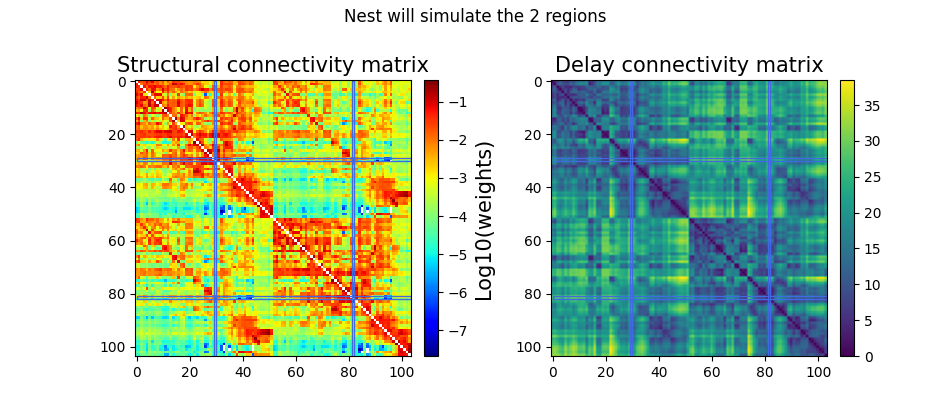

 Nest simulate the following regions :   Right_Entorhinal_area,_lateral_part, Left_Entorhinal_area,_lateral_part


<IPython.core.display.Javascript object>


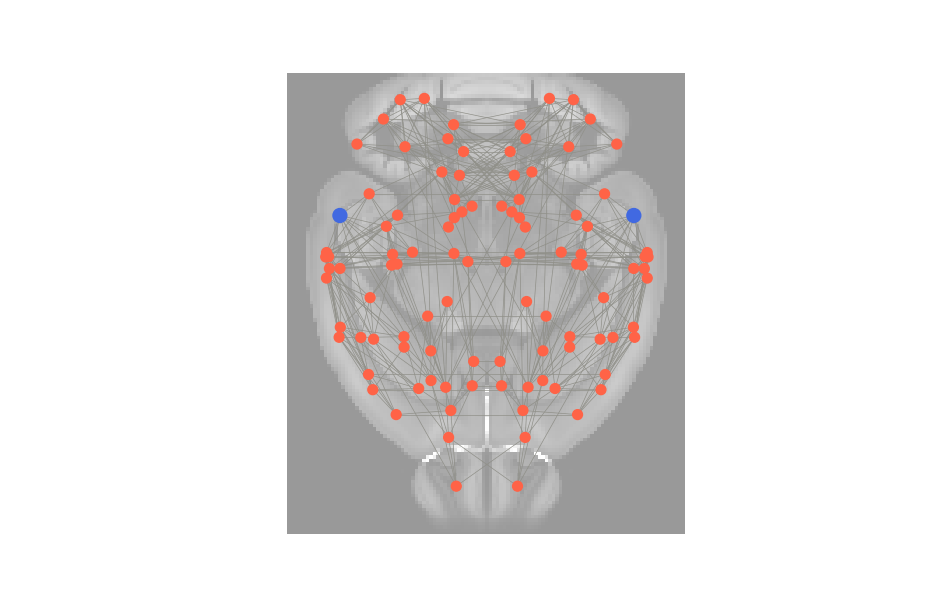

In [43]:
display_connectome(param,image='/home/nest_elephant_tvb/parameter/data_mouse//StruturalMRI_allen_40.npy',
                   color_Nest=color_Nest, color_TVB=color_TVB,
                   size_edges=0.5,
                   threshold=0.05)

# 2 Run the simulation

In [44]:
size_auto_scroll(10)

<IPython.core.display.Javascript object>

### parameter for running

In [45]:
begin=0.0
end=2000.0
folder_simulation = './test_sim_2/'
nb_MPI_nest = param['param_co_simulation']['nb_MPI_nest']

### save parameters <a id="create_link"></a>

In [46]:
if not os.path.exists(folder_simulation):
    os.mkdir(folder_simulation)
else:
    for root, dirs, files in os.walk(folder_simulation, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))
parameters = create_linked_parameters(folder_simulation,param)
save_parameter(parameters,folder_simulation,begin,end)

In [47]:
!mpirun -n {nb_MPI_nest} /usr/bin/python3.7 /home/nest_elephant_tvb/simulation/run_exploration.py {folder_simulation}/parameter.py

[INFO] [2020.7.18 10:5:40 /home/nest-io-dev/nestkernel/rng_manager.cpp:208 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2020.7.18 10:5:40 /home/nest-io-dev/nestkernel/rng_manager.cpp:251 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Jul 17 2020 15:35:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2020-07-18 10:05:41,130 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
time: 2020-07-18 10:05:41.529808 BEGIN SIMULATION 

Time to initialize the network: 0.03 s
[0, 800]
[800, 1000]
[0, 800]
[800, 1000]
2020-07-18 10:05:42,590 - WARNING - tvb.simulator.common - psutil modu

   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 150.5
   INFO   TVB start simulation 150.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 154.0
   INFO   TVB start simulation 154.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 157.5
   INFO   TVB start simulation 157.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 161.0
   INFO   TVB start simulation 161.0
   INFO   Nest end
   INFO   Nest run time 164.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 164.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 168.0
   INFO   TVB start simulation 168.0
   INFO   Nest end
   INFO   Nest run time 171.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 171.5
   INF

   INFO   Nest end
   INFO   Nest run time 353.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 353.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 357.0
   INFO   TVB start simulation 357.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 360.5
   INFO   TVB start simulation 360.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 364.0
   INFO   TVB start simulation 364.0
   INFO   Nest end
   INFO   Nest run time 367.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 367.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 371.0
   INFO   TVB start simulation 371.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 374.5
   INFO   TVB start simulation 374.5
   INF

   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 556.5
   INFO   TVB start simulation 556.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 560.0
   INFO   TVB start simulation 560.0
   INFO   Nest end
   INFO   Nest run time 563.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 563.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 567.0
   INFO   TVB start simulation 567.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 570.5
   INFO   TVB start simulation 570.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 574.0
   INFO   TVB start simulation 574.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 577.5
   INFO   TVB start simulation 577.5
   INF

   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 759.5
   INFO   TVB start simulation 759.5
   INFO   Nest end
   INFO   Nest run time 763.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 763.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 766.5
   INFO   TVB start simulation 766.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 770.0
   INFO   TVB start simulation 770.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 773.5
   INFO   TVB start simulation 773.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 777.0
   INFO   TVB start simulation 777.0
   INFO   Nest end
   INFO   Nest run time 780.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   TVB start simulation 780.5
   INF

   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 962.5
   INFO   TVB start simulation 962.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 966.0
   INFO   TVB start simulation 966.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 969.5
   INFO   TVB start simulation 969.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 973.0
   INFO   TVB start simulation 973.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 976.5
   INFO   TVB start simulation 976.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 980.0
   INFO   TVB start simulation 980.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 983.5
   INFO   TVB start simulation 983.5
   INF

   INFO   Nest end
   INFO   Nest run time 1162.0
   INFO   TVB start simulation 1162.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1165.5
   INFO   TVB start simulation 1165.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1169.0
   INFO   TVB start simulation 1169.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1172.5
   INFO   TVB start simulation 1172.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1176.0
   INFO   TVB start simulation 1176.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1179.5
   INFO   TVB start simulation 1179.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1183.0
   INFO   TVB start simulation 1183.0
   INFO   TVB end simulation
   INFO   TVB recei

   INFO   Nest end
   INFO   Nest run time 1361.5
   INFO   TVB start simulation 1361.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1365.0
   INFO   TVB start simulation 1365.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1368.5
   INFO   TVB start simulation 1368.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1372.0
   INFO   TVB start simulation 1372.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1375.5
   INFO   TVB start simulation 1375.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1379.0
   INFO   TVB start simulation 1379.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1382.5
   INFO   TVB start simulation 1382.5
   INFO   TVB end simulation
   INFO   TVB recei

   INFO   Nest end
   INFO   Nest run time 1561.0
   INFO   TVB start simulation 1561.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1564.5
   INFO   TVB start simulation 1564.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1568.0
   INFO   TVB start simulation 1568.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1571.5
   INFO   TVB start simulation 1571.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1575.0
   INFO   TVB start simulation 1575.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1578.5
   INFO   TVB start simulation 1578.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1582.0
   INFO   TVB start simulation 1582.0
   INFO   TVB end simulation
   INFO   TVB recei

   INFO   Nest end
   INFO   Nest run time 1760.5
   INFO   TVB start simulation 1760.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1764.0
   INFO   TVB start simulation 1764.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1767.5
   INFO   TVB start simulation 1767.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1771.0
   INFO   TVB start simulation 1771.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1774.5
   INFO   TVB start simulation 1774.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1778.0
   INFO   TVB start simulation 1778.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1781.5
   INFO   TVB start simulation 1781.5
   INFO   TVB end simulation
   INFO   TVB recei

   INFO   Nest end
   INFO   Nest run time 1960.0
   INFO   TVB start simulation 1960.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1963.5
   INFO   TVB start simulation 1963.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1967.0
   INFO   TVB start simulation 1967.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1970.5
   INFO   TVB start simulation 1970.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1974.0
   INFO   TVB start simulation 1974.0
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1977.5
   INFO   TVB start simulation 1977.5
   INFO   TVB end simulation
   INFO   TVB receive data
   INFO   Nest end
   INFO   Nest run time 1981.0
   INFO   TVB start simulation 1981.0
   INFO   TVB end simulation
   INFO   TVB recei

In [25]:
size_auto_scroll()

<IPython.core.display.Javascript object>

# 3 Show the result

## 3.1 Ploting the result from TVB

get the state variable of the all the node

In [47]:
folder_simulation = './test_sim_2/'

In [61]:
# get result 
nb_regions = param['param_nest_topology']["nb_region"]
result_raw = get_rate(folder_simulation+'/tvb/')[0] # result of the Raw monitor

times =  result_raw[0]
state_variable = np.concatenate(result_raw[1]).reshape(result_raw[1].shape[0],7,nb_regions) # shape : time, state variable, region

# costumize of the color of lines
ids =  param['param_co_simulation']["id_region_nest"]
color_lines = [color_TVB for i in range(nb_regions)]
for id in ids:
    color_lines[id] = color_Nest

custom_cycler = (cycler(color=plt.cm.jet(np.linspace(0, 1,nb_regions))))

the value for the populaiton simulate with Nest are correct only for the excitatory firing rate

In [25]:
hide_from('time series code')
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.plot(times,state_variable[:,0,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of exitatory population')
plt.subplot(222)
plt.plot(times,state_variable[:,1,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of inhibitory population')
plt.subplot(223)
plt.plot(times,state_variable[:,5,:]*1e3)
for i,j in enumerate(plt.gca().lines):
    j.set_color(color_lines[i])
plt.ylabel('Mean adpation of population')
plt.xlabel('time in ms')
plt.title('Mean adaptation of the populations')
plt.subplots_adjust(hspace=0.3)
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'times' is not defined

In [ ]:
hide_from('raster plot code')
fig=plt.figure(figsize=(9.5,8))
plt.gca().set_prop_cycle(custom_cycler)
max_rate_E = np.nanmax(state_variable[:,0,:])*1e3
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,0,i]*1e3+i*max_rate_E)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_E,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of exitatory population')
fig.tight_layout()

fig=plt.figure(figsize=(9.5,8))
plt.gca().set_prop_cycle(custom_cycler)
max_rate_I = np.nanmax(state_variable[:,1,:])*1e3
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,1,i]*1e3+i*max_rate_I)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_I,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('firing rate of inhibitory population')
fig.tight_layout()

fig=plt.figure(figsize=(9.5,8))
max_rate_adp = np.nanmax(state_variable[:,5,:])*1e3
plt.gca().set_prop_cycle(custom_cycler)
for i in range(int(nb_regions)):
    plt.plot(times,state_variable[:,5,i]*1e3+i*max_rate_adp)
if 'path_region_labels' in param['param_tvb_connection'].keys():
    labels = np.genfromtxt(param['param_tvb_connection']['path_region_labels'], dtype=str)
    plt.yticks(range(len(labels))*max_rate_adp,labels,size=4.5)
for i in ids:
    plt.gca().lines[i].set_linestyle('--')
plt.ylabel('Mean adpation of population')
plt.xlabel('time in ms')
plt.title('Mean adaptation of the populations')
fig.tight_layout()

plt.show()
size_auto_scroll(1000)

In [ ]:
size_auto_scroll()

## 3.2 Ploting data from Nest

In [26]:
data = get_data_all(folder_simulation+'/nest/')

/home/nest_elephant_tvb/analyse/get_data.py:110: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [27]:
data.keys()

dict_keys(['pop_1_ex_VM', 'pop_1_ex_W', 'pop_1_in_VM', 'pop_1_in_W', 'pop_1_ex', 'pop_2_ex', 'pop_1_in', 'pop_2_in'])

### 3.2.a Ploting the Voltage membrane

<IPython.core.display.Javascript object>


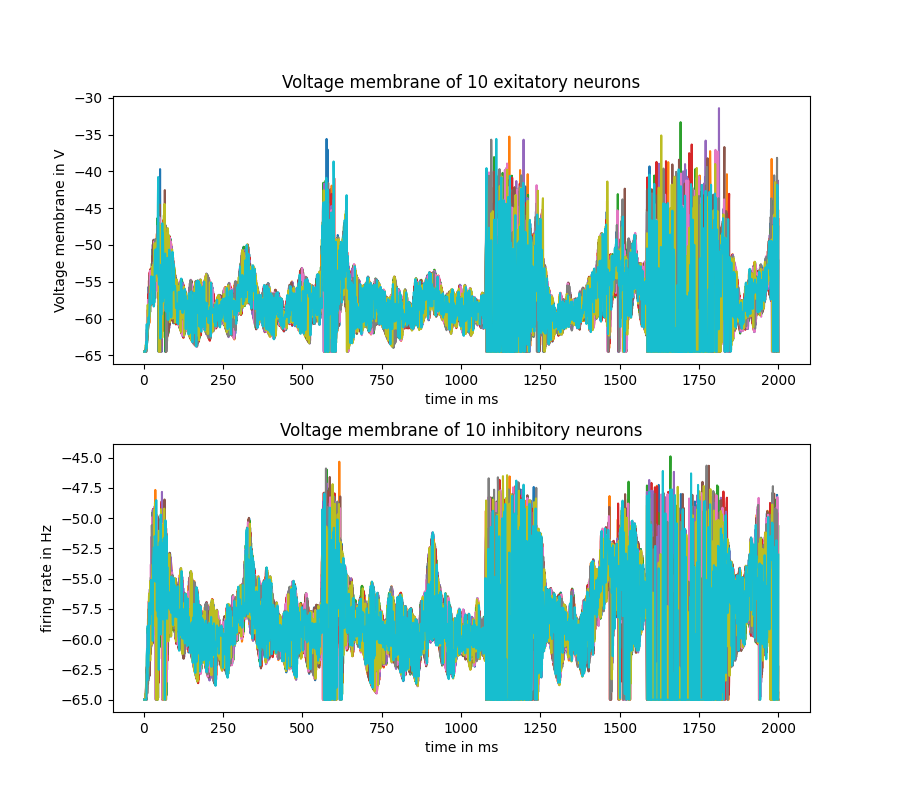

In [28]:
plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(data['pop_1_ex_VM'][1],np.swapaxes(data['pop_1_ex_VM'][2],0,1))
plt.ylabel('Voltage membrane in V')
plt.xlabel('time in ms')
plt.title('Voltage membrane of 10 exitatory neurons')
plt.subplot(212)
plt.plot(data['pop_1_in_VM'][1],np.swapaxes(data['pop_1_in_VM'][2],0,1))
plt.ylabel('firing rate in Hz')
plt.xlabel('time in ms')
plt.title('Voltage membrane of 10 inhibitory neurons')
plt.subplots_adjust(hspace=0.3)
plt.show()

<IPython.core.display.Javascript object>


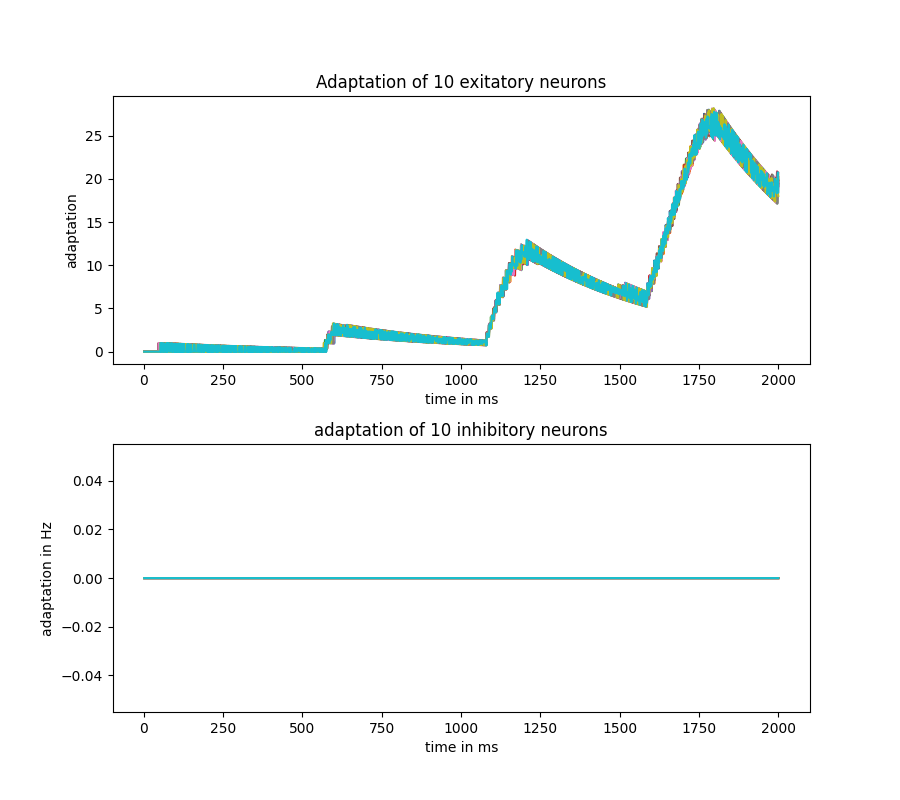

In [29]:
plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(data['pop_1_ex_W'][1],np.swapaxes(data['pop_1_ex_W'][2],0,1))
plt.ylabel('adaptation')
plt.xlabel('time in ms')
plt.title('Adaptation of 10 exitatory neurons')
plt.subplot(212)
plt.plot(data['pop_1_in_W'][1],np.swapaxes(data['pop_1_in_W'][2],0,1))
plt.ylabel('adaptation in Hz')
plt.xlabel('time in ms')
plt.title('adaptation of 10 inhibitory neurons')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 3.2.b Spike trains of the first region

<IPython.core.display.Javascript object>


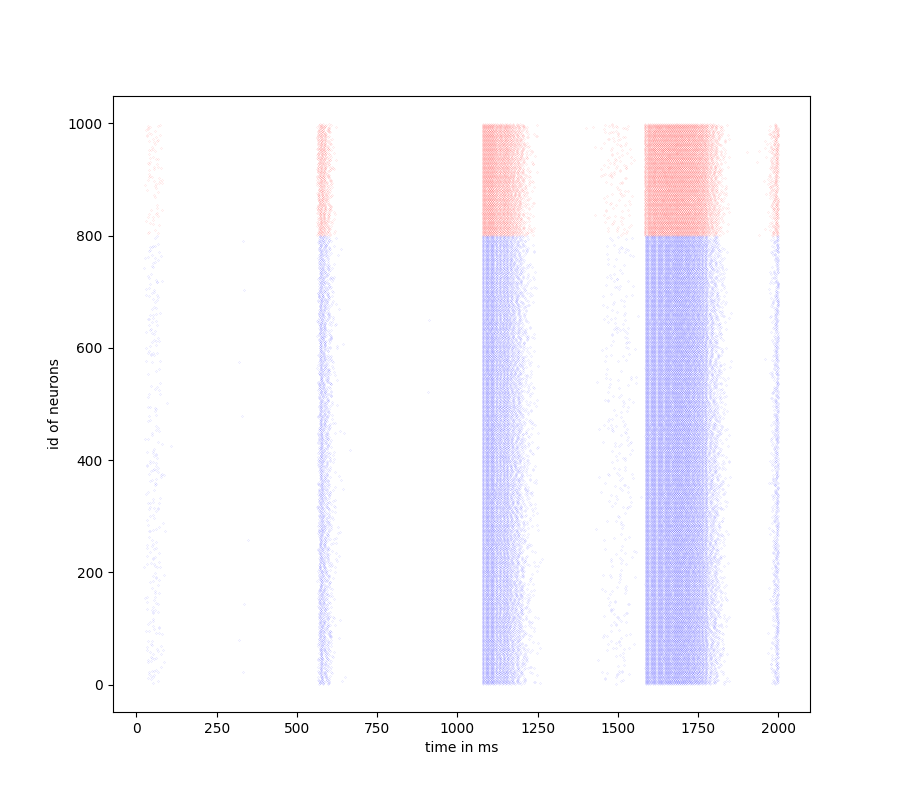

In [30]:
plt.figure(figsize=(9,8))
for i in range(data['pop_1_ex'][0].shape[0]):
    plt.plot(data['pop_1_ex'][1][i],np.repeat(data['pop_1_ex'][0][i],data['pop_1_ex'][1][i].shape[0]),'b.',markersize=0.1)
for i in range(data['pop_1_in'][0].shape[0]):
    plt.plot(data['pop_1_in'][1][i],np.repeat(data['pop_1_in'][0][i],data['pop_1_in'][1][i].shape[0]),'r.',markersize=0.1)
plt.ylabel('id of neurons')
plt.xlabel('time in ms')
plt.show()

<IPython.core.display.Javascript object>


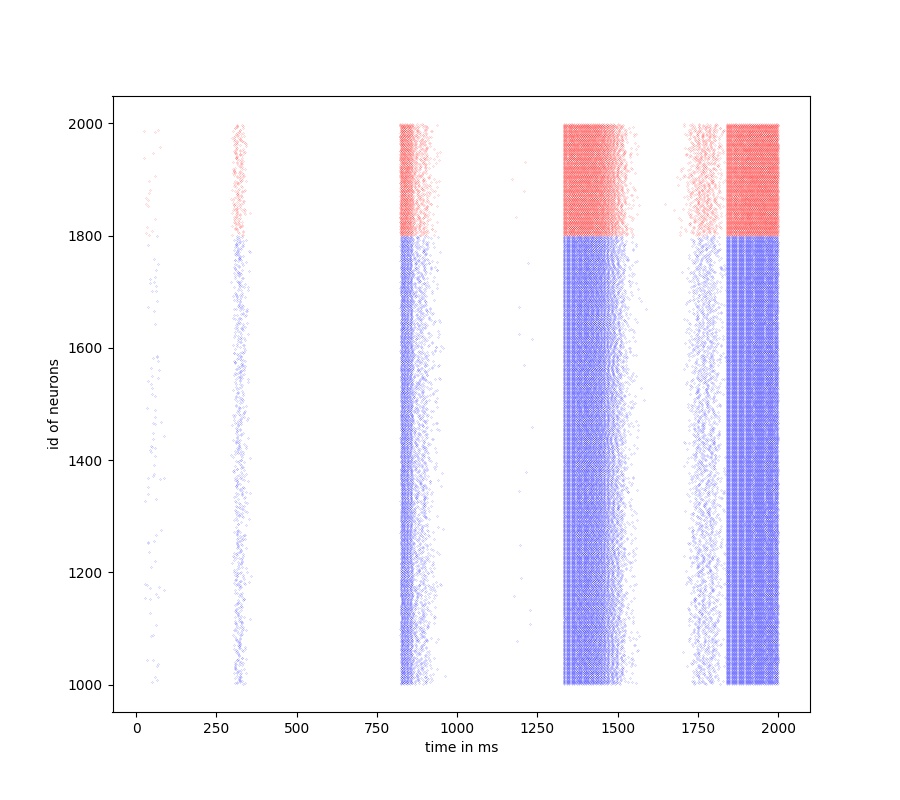

In [31]:
plt.figure(figsize=(9,8))
for i in range(data['pop_2_ex'][0].shape[0]):
    plt.plot(data['pop_2_ex'][1][i],np.repeat(data['pop_2_ex'][0][i],data['pop_2_ex'][1][i].shape[0]),'b.',markersize=0.2)
for i in range(data['pop_2_in'][0].shape[0]):
    plt.plot(data['pop_2_in'][1][i],np.repeat(data['pop_2_in'][0][i],data['pop_2_in'][1][i].shape[0]),'r.',markersize=0.2)
plt.ylabel('id of neurons')
plt.xlabel('time in ms')
plt.show()

## References

<a id='brette_2005'> [Brette and Gerstner 2005]</a>  Romain Brette and Wulfram Gerstner. “Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity.” Journal of Neurophysiology 94, no. 5 (November 1, 2005): 3637–42. https://doi.org/10.1152/jn.00686.2005.


<a id='di_volo2019'> [ Di Volo 2019 ]</a>  Matteo Di Volo, Alberto Romagnoni, Cristiano Capone, and Alain Destexhe. “Biologically Realistic Mean-Field Models of Conductance-Based Networks of Spiking Neurons with Adaptation.” Neural Computation 31, no. 4 (February 14, 2019): 653–80. https://doi.org/10.1162/neco_a_01173.

